In [11]:
import json
import numpy as np
import pandas as pd
import gensim
import networkx as nx

#import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from num2words import num2words
from pprint import pprint
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
parsed_sites = 'abs_dict.json'

print("Started Reading JSON file")
with open(parsed_sites, "r") as read_file:
    abstract_dict = json.load(read_file)
    print("Decoded JSON Data From File")

Started Reading JSON file
Decoded JSON Data From File


In [3]:
abstract_df = pd.DataFrame.from_dict(abstract_dict)
abstract_df.head()

,doi,titles,abstracts,authors,keywords,sources
0,10.3390,Community Faecal Management Strategies and Per...,Most people in rural areas in South Africa (SA...,"[Matthew Mamera, Johan J. van Tol, Makhosazana...",agriculture,mdpi
1,10.3390,Adoption of Sustainable Agriculture Practices ...,The aim of this study was to highlight the imp...,"[Rafay Waseem, Gershom Endelani Mwalupaso, Far...",agriculture,mdpi
2,10.3390,Atlanta Residents’ Knowledge Regarding Heavy M...,Urban agriculture and gardening provide many h...,"[Lauren Balotin, Samantha Distler, Antoinette ...",agriculture,mdpi
3,10.3390,Perceptions of the Challenges and Opportunitie...,Waste management has become pertinent in urban...,"[Nqubeko Neville Menyuka, Melusi Sibanda, Urmi...",agriculture,mdpi
4,10.3390,An Assessment of Seaweed Extracts: Innovation ...,Plant growth regulators (PGRs) are described i...,"[El Chami Daniel, Galli Fabio]",agriculture,mdpi


In [4]:
keywords = abstract_df.groupby('keywords').count()
keywords.head(60)

,doi,titles,abstracts,authors,sources
keywords,,,,,
CNN,279,279,279,279,279
agric,21,21,21,21,21
agricultural technology,80,80,80,80,80
agriculture,227,227,227,227,227
agriculture CNN,215,215,215,215,215
agriculture computer vision,193,193,193,193,193
agriculture deep learning,35,35,35,35,35
agriculture machine learning,230,230,230,230,230
agriculture object recognition,211,211,211,211,211


In [5]:
agri_labels = ["agronomy", "agriculture", "mildew", "wheat", "barley", "agric"]
ML_labels = ["CNN", "computer vision", "deep learning", "image segmentation", "machine learning", "neural networks", "object recognition", "supervised learning", "unsupervised learning"]

abstracts = abstract_dict['abstracts']
agri_abstracts = []
ML_abstracts = []
mix = []
for i in range (len(abstract_dict["abstracts"])):
    if abstract_dict["keywords"][i] in agri_labels:
        agri_abstracts.append(abstract_dict["abstracts"][i])
    elif abstract_dict["keywords"][i] in ML_labels:
        ML_abstracts.append(abstract_dict["abstracts"][i])
    else:
        mix.append(abstract_dict["abstracts"][i])
        



In [55]:



#corpus = developer['abstracts']

# Preprocessing

def convert_lower_case(data):
    return np.char.lower(data)

def remove_punctuation(data):
    symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"
    for i in range(len(symbols)):
        data = np.char.replace(data, symbols[i], ' ')
        data = np.char.replace(data, "  ", " ")
    data = np.char.replace(data, ',', '')
    return data

def remove_apostrophe(data):
    return np.char.replace(data, "'", "")

def stemming(data):
    stemmer= PorterStemmer()
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

def lemming(data):
    lemmatizer = WordNetLemmatizer() 
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        new_text = new_text + " " + lemmatizer.lemmatize(w)
    return new_text

def convert_numbers(data):
    tokens = word_tokenize(str(data))
    new_text = ""
    for w in tokens:
        try:
            w = num2words(int(w))
        except:
            a = 0
        new_text = new_text + " " + w
    new_text = np.char.replace(new_text, "-", " ")
    return new_text

def remove_stop_words(data):
    stop_words = stopwords.words('english')
    words = word_tokenize(str(data))
    new_text = ""
    for w in words:
        if w not in stop_words and len(w) > 1:
            new_text = new_text + " " + w
    return new_text



def preprocess(data):
    data = convert_lower_case(data)
    data = remove_punctuation(data)
    data = remove_apostrophe(data)
    data = remove_stop_words(data)
    data = convert_numbers(data)
    data = stemming(data)
    data = lemming(data)
    return data


# Preprocessing
def preprocess_corpus(corpus):
    preprocess_abstract = []
    for abstract in corpus:
        preprocess_abstract.append(word_tokenize(str(preprocess(abstract))))
        #list of lists of strings (words)
    return preprocess_abstract



"""
# Build the bigram and trigram models
# Careful: it might be worth creating th bigrams etc before dtemming and lemming
bigram = gensim.models.Phrases(preprocess_abstract) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[preprocess_abstract], threshold=100)  


# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
"""



def make_bigrams(preprocess_abstract):
    data_processed = []
    bigram = gensim.models.Phrases(preprocess_abstract)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    for abstract in preprocess_abstract:
        data_processed.append(bigram_mod[abstract])
    return data_processed






<>:9: DeprecationWarning: invalid escape sequence \]
<>:9: DeprecationWarning: invalid escape sequence \]
<>:9: DeprecationWarning: invalid escape sequence \]
<ipython-input-55-50b580fca04f>:9: DeprecationWarning: invalid escape sequence \]
  symbols = "!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n"


In [56]:
preprocess_abstract = preprocess_corpus(mix)
bigrams = make_bigrams(preprocess_abstract)
print(bigrams[:3])

[['introduct', 'field', 'base', 'phenotyp', 'promis', 'gather', 'inform', 'number', 'plant', 'per', 'plot', 'import', 'descript', 'plant', 'trait', 'agricultur', 'practic'], ['high', 'perform', 'comput', 'hpc', 'applic', 'essenti', 'scientist_engin', 'creat', 'understand', 'model', 'properti', 'profession', 'depend', 'execut', 'larg', 'set', 'comput', 'job', 'explor', 'combin', 'paramet', 'valu', 'avoid', 'execut', 'unnecessari', 'job', 'bring', 'speed', 'experi', 'also', 'reduct', 'infrastructur', 'usage—particularli', 'import', 'due', 'shift', 'applic', 'hpc', 'cloud_platform', 'hypothesi', 'data', 'gener', 'experi', 'help', 'user', 'identifi', 'job', 'address', 'hypothesi', 'need', 'understand', 'similar', 'level', 'among', 'multipl', 'experi', 'necessari', 'job', 'elimin', 'decis', 'step', 'requir', 'autom', 'process', 'paper_present', 'studi', 'machin_learn', 'base', 'tool_call', 'jobprun', 'support', 'paramet', 'explor', 'hpc', 'experi', 'tool', 'evalu', 'three', 'real_world', 'u

## TF-IDF part



In [57]:
preprocess_abstract = preprocess_corpus(mix)
bigrams = make_bigrams(preprocess_abstract)

for i in range (len(bigrams)):
    inter = ""
    for j in range (len(bigrams[i])):
        inter+=" " + bigrams[i][j]
    bigrams[i]=inter

print(bigrams)


#first step is to import the library
from sklearn.feature_extraction.text import TfidfVectorizer
#calling the TfidfVectorizer
tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(bigrams)

words = {}
for i in range (len(bigrams)):
    response = tfidf.transform([bigrams[i]])
    feature_names = tfidf.get_feature_names()

    for col in response.nonzero()[1]:
        if feature_names[col] not in words.keys():
            words[feature_names[col]] = response[0, col]
        else:
            words[feature_names[col]] += response[0, col]
print(words)

[' introduct field base phenotyp promis gather inform number plant per plot import descript plant trait agricultur practic', ' high perform comput hpc applic essenti scientist_engin creat understand model properti profession depend execut larg set comput job explor combin paramet valu avoid execut unnecessari job bring speed experi also reduct infrastructur usage—particularli import due shift applic hpc cloud_platform hypothesi data gener experi help user identifi job address hypothesi need understand similar level among multipl experi necessari job elimin decis step requir autom process paper_present studi machin_learn base tool_call jobprun support paramet explor hpc experi tool evalu three real_world use case differ domain_includ seismic analysi agronomi observ tool reduc nineti_three job singl experi improv qualiti scenario addit reduct job execut possibl even consid past_experi low correl', ' introduct appl one import fruit world china largest appl produc countri world take lot la

{'trait': 5.65116850137955, 'promis': 5.918612878939484, 'practic': 14.213628665170473, 'plot': 4.973295223224153, 'plant': 28.67485748880548, 'phenotyp': 7.541568320024884, 'per': 6.126954529715075, 'number': 13.587655013894409, 'introduct': 10.264597746341181, 'inform': 23.131269904166242, 'import': 18.72893647866547, 'gather': 2.1820860372926787, 'field': 29.755313855961955, 'descript': 3.0762993575705613, 'base': 44.207347900412564, 'agricultur': 58.950626345088374, 'valu': 16.31743494131997, 'user': 4.126415635396618, 'use': 70.5941586334094, 'usage': 0.23343984183807348, 'unnecessari': 0.5911444994772, 'understand': 7.578844590417678, 'tool_call': 0.6841499767922281, 'tool': 12.992019700897457, 'three': 20.66375886374771, 'support': 11.974910718430346, 'studi': 28.455334657076992, 'step': 7.8951368489288924, 'speed': 4.948636178202144, 'singl': 6.754857832411269, 'similar': 8.008668038651537, 'shift': 3.247141065891335, 'set': 12.702733000076485, 'seismic': 0.5491574816931626, 's

In [58]:
nbr_words=103
copy = words.copy()


copy.pop("use")
copy.pop("two")
copy.pop("one")
copy.pop("data")


max_words = []



for i in range (nbr_words):
    maximum = max(copy, key=copy.get)  
    print(maximum, copy[maximum])
    max_words.append(maximum)
    copy.pop(maximum)
    

model 59.83290442544448
agricultur 58.950626345088374
imag 54.56352936534585
method 45.48755200820845
base 44.207347900412564
detect 44.20093142747362
crop 42.91492376269184
system 41.465599186736476
farm 40.56997785381264
predict 38.39629466276421
technolog 36.50402588225423
algorithm 35.185048267427526
develop 34.06061870493095
perform 32.925184231322746
product 31.498240865154077
differ 30.98310462742824
approach 30.457818993316007
machin_learn 30.131976930819967
applic 30.094393923485374
field 29.755313855961955
propos 29.322882828828728
improv 29.036640121482243
plant 28.67485748880548
studi 28.455334657076992
classif 27.158781078985996
result 26.702244734598743
dataset 26.571408646809257
process 25.978385644444675
techniqu 25.340211448765363
network 25.053085602134548
fruit 25.03120279115594
farmer 24.68959069837156
research 23.982070399189556
manag 23.485529975646347
accuraci 23.459967258335734
estim 23.4011925337802
inform 23.131269904166242
provid 22.9597608720807
analysi 22.2

In [59]:
def co_occurence(max_words, corpus):
    matrix_dict = {}
    matrix = np.zeros((len(max_words), len(max_words)))
    for i in range (len(max_words)-1):
        for j in range (i+1, len(max_words)):
            matrix_dict[max_words[i]+" "+max_words[j]] = 0
            for abstract in corpus:
                if (max_words[i] in abstract) and (max_words[j] in abstract):
                    matrix[i,j]+=1
                    matrix[j,i]+=1
                    matrix_dict[max_words[i]+" "+max_words[j]] +=1
                    
                    
    print(matrix)
    return matrix, matrix_dict

co_matrix, matrix_dict = co_occurence(max_words, bigrams)  # the matrix is normally symetrical but it doesn't matter much here         

[[  0. 331. 335. ... 113. 133. 425.]
 [331.   0. 353. ... 148. 108. 435.]
 [335. 353.   0. ...  91. 121. 490.]
 ...
 [113. 148.  91. ...   0.  36. 142.]
 [133. 108. 121. ...  36.   0. 171.]
 [425. 435. 490. ... 142. 171.   0.]]


In [60]:
copy = matrix_dict.copy()
nbr_bigrams=100

d = {}
for i in range (nbr_words):
    maximum = max(copy, key=copy.get)  
    print(maximum, copy[maximum])
    d[maximum] = copy[maximum]
    copy.pop(maximum)
print(d)

accuraci accur 621
network work 596
base result 570
result ass 563
method result 560
base ass 558
method base 545
result show 532
applic appli 524
method ass 521
result work 512
classif ass 508
high ass 507
base work 503
studi result 495
base accur 494
base high 492
imag ass 490
accur ass 490
work ass 482
imag method 481
imag base 477
method work 473
result high 472
method accur 471
studi ass 471
result accur 466
evalu valu 463
imag result 462
imag work 451
accur work 450
perform ass 448
imag accur 447
model base 446
agricultur base 443
model result 441
method high 441
base appli 441
high work 438
agricultur ass 435
model high 433
base propos 432
perform work 429
model work 426
agricultur appli 426
base studi 426
differ result 426
model ass 425
agricultur work 425
perform result 425
result appli 425
appli ass 424
method perform 419
high accur 419
base develop 418
base perform 418
result valu 418
agricultur result 417
method propos 417
accuraci ass 416
result three 414
three ass 414
agr

['accuraci', 'accur'] 621
['network', 'work'] 596
['base', 'result'] 570
['result', 'ass'] 563
['method', 'result'] 560
['base', 'ass'] 558
['method', 'base'] 545
['result', 'show'] 532
['applic', 'appli'] 524
['method', 'ass'] 521
['result', 'work'] 512
['classif', 'ass'] 508
['high', 'ass'] 507
['base', 'work'] 503
['studi', 'result'] 495
['base', 'accur'] 494
['base', 'high'] 492
['imag', 'ass'] 490
['accur', 'ass'] 490
['work', 'ass'] 482
['imag', 'method'] 481
['imag', 'base'] 477
['method', 'work'] 473
['result', 'high'] 472
['method', 'accur'] 471
['studi', 'ass'] 471
['result', 'accur'] 466
['evalu', 'valu'] 463
['imag', 'result'] 462
['imag', 'work'] 451
['accur', 'work'] 450
['perform', 'ass'] 448
['imag', 'accur'] 447
['model', 'base'] 446
['agricultur', 'base'] 443
['model', 'result'] 441
['method', 'high'] 441
['base', 'appli'] 441
['high', 'work'] 438
['agricultur', 'ass'] 435
['model', 'high'] 433
['base', 'propos'] 432
['perform', 'work'] 429
['model', 'work'] 426
['agr

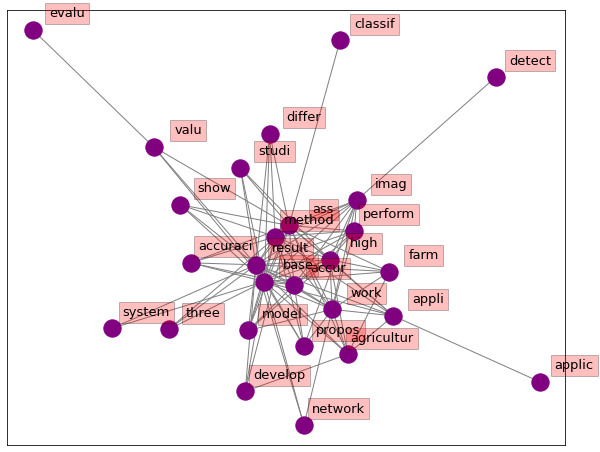

In [61]:
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d.items():

    k=k.split(" ")
    print(k, v)
    G.add_edge(k[0], k[1], weight=(v * 10))


fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=1,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()


In [ ]:
feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 3
top_n = feature_array[tfidf_sorting][:n]
print(top_n)

In [52]:
def build_LDA(corpus):
    preprocess_abstract = preprocess_corpus(corpus)
    bigrams = make_bigrams(preprocess_abstract)

    # Create Dictionary
    id2word = gensim.corpora.Dictionary(bigrams)

    # Create Corpus
    texts = bigrams

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    """
    # View
    print(corpus[:1])
    # Human readable format of corpus (term-frequency)
    print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])
    """


    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=20, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=True)

    """
    # Print the Keyword in the 10 topics
    pprint(lda_model.print_topics())
    doc_lda = lda_model[corpus]
    """

    # Visualize the topics
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    return vis


build_LDA(agri_abstracts)

KeyboardInterrupt: 

In [13]:
build_LDA(ML_abstracts)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13     0.367160  0.074915       1        1  31.214282
15     0.388125  0.102298       2        1  29.148388
2      0.329049  0.131342       3        1  16.500008
12     0.245219 -0.284690       4        1   7.118107
7      0.097314 -0.243057       5        1   3.257058
3      0.072737  0.070802       6        1   2.943188
6     -0.045548 -0.058962       7        1   2.469018
0     -0.045066  0.013632       8        1   1.640276
9     -0.075056  0.018596       9        1   1.152276
16    -0.089611 -0.016044      10        1   0.928064
8     -0.115106  0.012663      11        1   0.691384
14    -0.110028  0.005659      12        1   0.591040
1     -0.123340  0.020166      13        1   0.520630
5     -0.117300  0.016110      14        1   0.497287
11    -0.118693  0.019193      15        1   0.446683
10    -0.130887  0.022661      16        1   0.263113
17    -0.131445  0.023822      17        1   0.202897
4     -0.133352  0.023274      18        1   0.161751
18    -0.131416  0.023335      19        1   0.144111
19    -0.132756  0.024284      20        1   0.110440, topic_info=                   Term         Freq        Total Category  logprob  loglift
29                learn  1306.000000  1306.000000  Default  30.0000   30.000
87                model  2425.000000  2425.000000  Default  29.0000   29.000
206                  de   508.000000   508.000000  Default  28.0000   28.000
53                train  1424.000000  1424.000000  Default  27.0000   27.000
26                 imag  1462.000000  1462.000000  Default  26.0000   26.000
...                 ...          ...          ...      ...      ...      ...
9421            regener     0.013648     0.854889  Topic20  -9.3923    2.671
5821             partli     0.013648     0.854891  Topic20  -9.3923    2.671
8613          unpredict     0.013648     0.854892  Topic20  -9.3923    2.671
8662  candlestick_chart     0.013648     0.854898  Topic20  -9.3923    2.671
3633             extent     0.013648     0.854896  Topic20  -9.3923    2.671

[838 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
1738      9  0.921743          ,_four
2242      1  0.357697              3d
2242      5  0.631678              3d
2978     15  0.852151      5g_network
490       1  0.996835             abl
...     ...       ...             ...
2774     10  0.923208  without_requir
1022      1  0.836678            work
1022      2  0.064551            work
1022      3  0.096826            work
2789     13  0.952635        workflow

[963 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 16, 3, 13, 8, 4, 7, 1, 10, 17, 9, 15, 2, 6, 12, 11, 18, 5, 19, 20])

In [15]:
build_LDA(mix)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.374108  0.042594       1        1  33.037645
14     0.375618 -0.105944       2        1  25.304315
6      0.336616 -0.097631       3        1  14.380423
19     0.159690  0.403147       4        1   8.966454
17     0.202583 -0.127830       5        1   6.220187
12     0.009147  0.041990       6        1   2.984238
3      0.071869 -0.007325       7        1   1.759440
13    -0.094909  0.020294       8        1   1.245325
7     -0.058451 -0.030068       9        1   1.037542
16    -0.063313 -0.004099      10        1   0.992169
5     -0.105735 -0.005166      11        1   0.655120
9     -0.140278 -0.015682      12        1   0.625420
2     -0.092331 -0.009080      13        1   0.562959
1     -0.137058 -0.015098      14        1   0.496998
4     -0.122101 -0.012422      15        1   0.424158
0     -0.141795 -0.013277      16        1   0.413616
15    -0.138229 -0.015625      17        1   0.394433
18    -0.144007 -0.016147      18        1   0.209024
11    -0.145417 -0.016287      19        1   0.170779
8     -0.146008 -0.016343      20        1   0.119757, topic_info=            Term         Freq        Total Category  logprob  loglift
992         farm  2939.000000  2939.000000  Default  30.0000  30.0000
183       detect  1569.000000  1569.000000  Default  29.0000  29.0000
203         imag  1516.000000  1516.000000  Default  28.0000  28.0000
0     agricultur  2614.000000  2614.000000  Default  27.0000  27.0000
33          data  2356.000000  2356.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2374        gain     0.015908     1.065735  Topic20  -9.8976   2.5229
2239       count     0.015908     1.065771  Topic20  -9.8976   2.5228
3036     prevent     0.015908     1.065716  Topic20  -9.8976   2.5229
3707      manner     0.015908     1.065719  Topic20  -9.8976   2.5229
3193      infrar     0.015908     1.065890  Topic20  -9.8976   2.5227

[843 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
2178      4  0.993442         ,_nine
2036     11  0.995634        absorpt
1088      3  0.997199         access
268       1  0.629270       accuraci
268       2  0.018219       accuraci
...     ...       ...            ...
1344      9  0.943939             •a
1216     13  0.708820        •differ
970       9  0.923527  •machin_learn
1217     13  0.804537         •model
831       7  0.987491           •the

[929 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 15, 7, 20, 18, 13, 4, 14, 8, 17, 6, 10, 3, 2, 5, 1, 16, 19, 12, 9])

In [16]:


# To use the Mallet LDA you must download this:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip


def mallet_LDA(corpus, num_topics):
    preprocess_abstract = preprocess_corpus(corpus)
    bigrams = make_bigrams(preprocess_abstract)

    # Create Dictionary
    id2word = gensim.corpora.Dictionary(bigrams)

    # Create Corpus
    texts = bigrams

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    mallet_path = 'mallet-2.0.8/bin/mallet' 
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

    # Show Topics
    pprint(ldamallet.show_topics(formatted=False))

    # Compute Coherence Score
    coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=bigrams, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()
    print('\nCoherence Score: ', coherence_ldamallet)
    return ldamallet, coherence_ldamallet

In [17]:
mallet_LDA(mix, 20)

[(7,
  [('system', 0.018708381777824756),
   ('monitor', 0.015008984251136243),
   ('automat', 0.014586195962371842),
   ('measur', 0.013212134023887538),
   ('video', 0.013106436951696438),
   ('behavior', 0.012683648662932036),
   ('activ', 0.01056970721911003),
   ('record', 0.01056970721911003),
   ('time', 0.01035831307472783),
   ('highlight', 0.00993552478596343)]),
 (6,
  [('product', 0.06804830287206266),
   ('agricultur', 0.05099543080939948),
   ('develop', 0.03214751958224543),
   ('process', 0.01852154046997389),
   ('strategi', 0.01558420365535248),
   ('produc', 0.014115535248041775),
   ('studi', 0.014115535248041775),
   ('research', 0.014033942558746737),
   ('implement', 0.012973237597911228),
   ('increas', 0.01060704960835509)]),
 (16,
  [('method', 0.06391354689309148),
   ('imag', 0.0419915090698572),
   ('featur', 0.033114627556927824),
   ('algorithm', 0.021999228097259745),
   ('recognit', 0.01883442686221536),
   ('base', 0.01875723658818989),
   ('elsevi', 0

(<gensim.models.wrappers.ldamallet.LdaMallet at 0x7f144b1b2668>,
 0.5290494008184112)

In [18]:
def compute_coherence_values(corpus, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model, coherencemodel = mallet_LDA(corpus, num_topics)
        model_list.append(model)
        coherence_values.append(coherencemodel)

    return model_list, coherence_values

In [21]:
# Can take a long time to run.
start=8
limit=31
step=2
model_list, coherence_values = compute_coherence_values(corpus=mix, start=start, limit=limit, step=step)

[(0,
  [('system', 0.03510748146062142),
   ('crop', 0.020870490315717014),
   ('applic', 0.019775337150724364),
   ('plant', 0.018367283081448107),
   ('base', 0.016396007384461342),
   ('process', 0.01401796051190588),
   ('control', 0.012797646985199787),
   ('develop', 0.011420883006351887),
   ('requir', 0.010951531649926469),
   ('field', 0.01004411902750399)]),
 (1,
  [('farm', 0.01583050032622506),
   ('data', 0.00961505442807596),
   ('machin_learn', 0.009065622746471618),
   ('differ', 0.00882524638576972),
   ('cow', 0.008516191064867278),
   ('techniqu', 0.007279969781257512),
   ('level', 0.007176951340956698),
   ('pig', 0.00697091446035507),
   ('studi', 0.006833556539953985),
   ('approach', 0.006833556539953985)]),
 (2,
  [('imag', 0.024265333495915132),
   ('dataset', 0.018229484209242777),
   ('network', 0.01774173881233996),
   ('perform', 0.016857700280453605),
   ('propos', 0.015089623216680892),
   ('field', 0.013230093890988904),
   ('train', 0.01298622119253749


Coherence Score:  0.5053466640989205
[(4,
  [('model', 0.10510134365748121),
   ('predict', 0.029150535185606924),
   ('perform', 0.023969483033477568),
   ('machin_learn', 0.016795718515144616),
   ('approach', 0.014347529036665908),
   ('algorithm', 0.012184012753359143),
   ('power', 0.011273058528808928),
   ('base', 0.01115918925074015),
   ('method', 0.011045319972671374),
   ('gener', 0.010988385333636984)]),
 (6,
  [('predict', 0.02684008276677505),
   ('machin_learn', 0.01501625775938516),
   ('cow', 0.014661543009163464),
   ('model', 0.01418859000886787),
   ('method', 0.012710611882944133),
   ('studi', 0.011646467632279042),
   ('milk', 0.010464085131540053),
   ('anim', 0.010050251256281407),
   ('evalu', 0.00981377475613361),
   ('record', 0.009459060005911913)]),
 (10,
  [('de', 0.0340702210663199),
   ('develop', 0.02531426094495015),
   ('le', 0.020546163849154746),
   ('product', 0.017598612917208496),
   ('highlight', 0.014044213263979194),
   ('strategi', 0.013524


Coherence Score:  0.5457400107738438
[(19,
  [('estim', 0.02317421460628315),
   ('differ', 0.014443084455324358),
   ('yield', 0.014116687066503469),
   ('valu', 0.013055895552835577),
   ('result', 0.012403100775193798),
   ('plant', 0.012321501427988575),
   ('varieti', 0.01142390860873113),
   ('statu', 0.01109751121991024),
   ('select', 0.010526315789473684),
   ('appli', 0.009873521011831905)]),
 (5,
  [('de', 0.060377938239360884),
   ('le', 0.03318482101705331),
   ('highlight', 0.025503149485328006),
   ('la', 0.022123214011368873),
   ('en', 0.013673375326471041),
   ('•the', 0.013058841603933016),
   ('el', 0.011676140728222461),
   ('de_la', 0.008757105546166846),
   ('se', 0.008296205254263328),
   ('urban_farm', 0.006606237517283761)]),
 (6,
  [('time', 0.027036132401246527),
   ('measur', 0.025520087593699992),
   ('determin', 0.015918470479238608),
   ('develop', 0.014149751537100986),
   ('paramet', 0.012717931441084815),
   ('sampl', 0.011538785479659731),
   ('ten'


Coherence Score:  0.526251863628788
[(0,
  [('base', 0.02732539075308777),
   ('pig', 0.02218821729150727),
   ('system', 0.015958028199803256),
   ('monitor', 0.015958028199803256),
   ('automat', 0.014865012569679746),
   ('video', 0.01420920319160564),
   ('behavior', 0.013990600065580937),
   ('measur', 0.013553393813531534),
   ('process', 0.01311618756148213),
   ('detect', 0.011039457864247459)]),
 (13,
  [('detect', 0.08329070758738277),
   ('imag', 0.056947996589940326),
   ('method', 0.05541346973572037),
   ('base', 0.021909633418584824),
   ('accuraci', 0.021398124467178176),
   ('algorithm', 0.021057118499573743),
   ('propos', 0.019096334185848253),
   ('featur', 0.018499573742540496),
   ('segment', 0.015942028985507246),
   ('recognit', 0.015174765558397273)]),
 (11,
  [('model', 0.1219409282700422),
   ('predict', 0.07763713080168777),
   ('machin_learn', 0.04177215189873418),
   ('data', 0.03029535864978903),
   ('algorithm', 0.022953586497890296),
   ('perform', 0.0


Coherence Score:  0.5272191025340842


[0.5324737350040724, 0.49874179743875874, 0.5053466640989205, 0.514481551683011, 0.5200433095690078, 0.5457400107738438, 0.5294032670517368, 0.5206582593001786, 0.526251863628788, 0.5145115063767669, 0.5107671400640362, 0.5272191025340842]


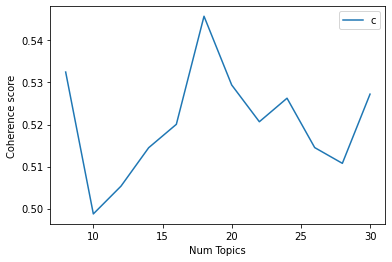

In [22]:
# Show graph
print(coherence_values)
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
print(coherence_values)

[0.43157396307582285, 0.46263787110455074, 0.44300858554782263, 0.4471199758451803, 0.42981042058242697, 0.4447975748186329, 0.4373850803489953, 0.4483284603157475, 0.43000401484674317, 0.4284624813494124, 0.4342444364948314, 0.4366804641021528]


In [23]:
optimal_model, coherence = mallet_LDA(corpus=mix, num_topics=18)
print(optimal_model)

[(3,
  [('crop', 0.05481874447391689),
   ('estim', 0.025788387857353375),
   ('base', 0.019451812555260833),
   ('harvest', 0.01584143825523136),
   ('yield', 0.014294134983790157),
   ('uav', 0.011567933981727086),
   ('measur', 0.011125847332743884),
   ('applic', 0.010683760683760684),
   ('develop', 0.009062776304155614),
   ('order', 0.008768051871500147)]),
 (16,
  [('urban', 0.02140429532142599),
   ('sustain', 0.015836286065514498),
   ('system', 0.014028490852556223),
   ('energi', 0.013956179044037892),
   ('practic', 0.013449996384409574),
   ('horticultur', 0.013305372767372913),
   ('greenhous', 0.01171451297996963),
   ('environ', 0.010340588618121338),
   ('distribut', 0.009545158724419698),
   ('cultiv', 0.009111287873309712)]),
 (15,
  [('two_thousand', 0.031363088057901084),
   ('thousand_,', 0.030382991556091678),
   ('hundr_and', 0.026311821471652595),
   ('thousand_and', 0.023522316043425813),
   ('one_hundr', 0.02141133896260555),
   ('one_thousand', 0.0167370325

In [24]:
corpus = mix
preprocess_abstract = preprocess_corpus(corpus)
bigrams = make_bigrams(preprocess_abstract)

# Create Dictionary
id2word = gensim.corpora.Dictionary(bigrams)

# Create Corpus
texts = bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
mallet_path = 'mallet-2.0.8/bin/mallet' 
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=24, id2word=id2word)


def format_topics_sentences(ldamodel, corpus, texts = bigrams):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)



,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.1330,"crop, estim, base, harvest, yield, uav, measur...","[introduct, field, base, phenotyp, promis, gat..."
1,1,4.0,0.3184,"dataset, perform, imag, agricultur, deep_learn...","[high, perform, comput, hpc, applic, essenti, ..."
2,2,7.0,0.1605,"agricultur, product, technolog, develop, resea...","[introduct, appl, one, import, fruit, world, c..."
3,3,11.0,0.1768,"data, map, field, crop, area, studi, base, lan...","[introduct, potato, crop, solarium, tuberosum,..."
4,4,15.0,0.1340,"two_thousand, thousand_,, hundr_and, thousand_...","[introduct, two_thousand, and_seventeen, peach..."
5,5,7.0,0.1146,"agricultur, product, technolog, develop, resea...","[introduct, rapid, popul_growth, develop_count..."
6,6,3.0,0.1078,"crop, estim, base, harvest, yield, uav, measur...","[introduct, unman_aircraft, system, uass, disc..."
7,7,11.0,0.3706,"data, map, field, crop, area, studi, base, lan...","[recent_year, unman_aerial, system_ua, emerg, ..."
8,8,6.0,0.5819,"system, differ, optim, control, design, oper, ...","[oil_palm, industri, vital, malaysian, economi..."
9,9,17.0,0.4466,"water, valu, treatment, determin, increas, yea...","[compar, differ, analyt, method, explain, crop..."


In [66]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

    
Document_No = list(sent_topics_sorteddf_mallet.index)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

#keep Document_No
sent_topics_sorteddf_mallet["Document_No"] = Document_No

# Show
sent_topics_sorteddf_mallet.head(40)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Document_No
0,0.0,0.5093,"product, level, test, work, harvest, studi, im...","[andrographolid, ag, encapsul, human, albumin,...",881
1,1.0,0.5156,"object, region, local, imag, method, base, fie...","[applic, digit, agricultur, servic, often, req...",422
2,2.0,0.5869,"detect, method, propos_method, propos, leav, t...","[fast_accur, detect, ripe_tomato, plant, repla...",646
3,3.0,0.7053,"imag, dataset, agricultur, challeng, perform, ...","[success, deep_learn, visual, recognit, task, ...",438
4,4.0,0.4488,"map, data, crop, remot_sen, area, classif, lan...","[map, high_resolut, thirti, better, cropland_e...",261
5,5.0,0.5178,"base, algorithm, monitor, behavior, identifi, ...","[simpl, summari, requir, dairi, product, incre...",1149
6,6.0,0.6114,"segment, imag, algorithm, propos, base, label,...","[emerg, 4d, heart_imag, make, data, volum, ima...",21
7,7.0,0.4533,"agricultur, applic, technolog, develop, resear...","[rapid, growth, urban, popul, worldwid, impos,...",426
8,8.0,0.6472,"estim, perform, techniqu, base, process, data,...","[hyperspectr_imag, hsi, power, technolog, alre...",188
9,9.0,0.5406,"experi, comput, network, propos, due, effici, ...","[high, perform, comput, hpc, applic, essenti, ...",129


In [67]:
for i in range (24):
    print(mix[sent_topics_sorteddf_mallet["Document_No"][i]])

Andrographolide (AG) was encapsulated in human albumin nanoparticles (AG NPs), and their crossing properties of the blood-brain barrier (BBB), brain distribution, and effects in TgCRND8 mice were evaluated. The development of appropriate NP formulations is mandatory because of the scarce BBB permeability properties of AG. Developed NPs had proper size (mean size: 159.2 ± 4.5 nm), size distribution (PDI nearby 0.12 ± 0.01), and ζ potential (-24.8 ± 1.2 mV), which were not affected by sodium fluorescein (NAF) loading. When AG was loaded to NPs, it slightly affected their size (210.4 ± 3.2 nm) and ζ potential (-20.3 ± 1.5) but not the PDI. Both NAF and AG had a remarkable encapsulation efficiency (more than 99%). The in vitro release of AG from the NPs reached the highest percentage (48%) after 24 h, and the Higuchi’s equation was found to be the best fitting model (R2 = 0.9635). Both AG and AG NPs did not alter the viability of N2a murine neuroblastoma cells when compared with the untrea